# Colormaps in Python with Matplotlib

This notebook gives a practical introduction to using colors in graphics in Python. The matplotlib package has excellent support for managing colors and plots, however, it can sometimes be a bit tricky to find out how to combine the various different classes in this package. This notebook gives a few examples.
Choosing a good colormap is a science in and of itself and some great resources about that topic are available.  This post focuses on the what to do once you have chosen the colormap you want.
We will start by making some example plots to work with, then we will fine-tune existing color maps, and finally we will show how to make a custom color map.

### Getting some data to work with

For this tutorial, we will use a two data sets related to international trade. One data set shows the location of ocean traffic around Denmark. A second data set, shows imports and exports over the last 20 years from/to the USA. See the end of the notebook for links.

I've done some data preprocessing, can details can be found in a separate notebook. The preprocessed data are located in a folder called sample_data.
Let's start by loading the data.

In [1]:
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
from datetime import date
import seaborn
import requests

import numpy as np
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape
from descartes.patch import PolygonPatch
from scipy.sparse import load_npz

from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm, PowerNorm, Normalize, LinearSegmentedColormap

from zipfile import ZipFile
import shutil
import os

seaborn.set_style('darkgrid')

font_size = 16
params = {'axes.labelsize': font_size,
          'axes.titlesize':font_size, 
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size, 
          'ytick.labelsize': font_size,}

matplotlib.rcParams.update(params)

%matplotlib inline


## Data for Line plots

In [2]:
# Load data for line plots
data = pd.read_excel('sample_data/realimp.xls')
data = data.iloc[:, [0,6]]  # only select imports of cosumer goods
data.columns = ['month', 'imports']

# the xls file is organized by vertical sections, so we only extract rows that start with the name of a month.
months = [date(2017, 1 + i, 1).strftime('%B') for i in range(12)]
data = data.loc[data.month.isin(months), :]

# infer year from the row number
data['year'] = [1994 + i // 12 for i in range(len(data))]

# include 17 years
data = data.iloc[0:12 * 17]

line_data = data
line_data.tail()

,month,imports,year
239,August,42638,2010
240,September,41722,2010
241,October,42692,2010
242,November,41052,2010
243,December,41568,2010


In [3]:
# define a reusable plotting function for the line data

def plot_lines(data, ax, cmap=None, norm=None):
    for year in sorted(data.year.unique(), reverse=True):
        year_data = data.loc[data.year==year, :]
        if cmap is not None:
            norm_value = norm(year)
            col = cmap(norm_value)
        else:
            col = None
        ax.plot(year_data['month'],
                year_data['imports'], 
                lw=2, 
                c=col, 
                label=year)
    plt.xticks(rotation=40)
    plt.yticks()
    plt.ylabel('2009 Dollars, in Millions')
    legend = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=True)
    legend.get_frame().set_facecolor('w')
    plt.title('Imports of Consumer Goods to USA, by Year')

## Data for density plots
### Shape files
We will draw local geography of Denmark from a shapefile. Here we download and chache that shape file.

In [4]:
local_path = 'sample_data/gadm36_DNK_shp.zip'
if not os.path.exists(local_path):
    r = requests.get('https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_DNK_shp.zip')
    #r = requests.get(settings.STATICMAP_URL.format(**data), stream=True)
    print(r.status_code)
    if r.status_code == 200:
        with open(local_path, 'wb') as f:
            for chunk in r:
                f.write(chunk)
            
zf = ZipFile(local_path)
for file in zf.namelist():
    if '_0' in file:
        zf.extract(file,path='sample_data')

### Density Data

In [5]:
# load preprocessed data and convert to sparse matrix

sparse_matrix = load_npz('sample_data/density.npz')
values = sparse_matrix.astype(np.float64).todense().transpose()

In [6]:
# define a reusable plotting function for the density plots
# this function uses imshow to plot a density map and draws geographic boundaries from a shape file.
def plot_density(data, ax, cmap=None, norm=None, annotation=None):
    """Plot a density map of shipping traffic. """
    
    bounds = [10, 11, 57, 58]
    figsize = np.array([bounds[1]-bounds[0], bounds[3]-bounds[2]])*3
    
    if cmap is None:
        im = ax.imshow(np.log(data+1),
                  origin='lower',
                  extent=bounds)
        plt.colorbar(im)
    else:
        # the cmap and norm classes are passed directly to the imshow function
        im = ax.imshow(data,
                       cmap=cmap,
                       norm=norm,
                       origin='lower',
                       extent=bounds) 
        plt.colorbar(im,ticks=np.arange(0, norm.vmax, norm.vmax/10))
    
    try:
        shapefile = fiona.open('sample_data/gadm36_DNK_0.shp')

        for country in shapefile:
            p = shape(country['geometry'])
            patch = PolygonPatch(p,
                                 fill=True,
                                 alpha=.5,
                                 edgecolor='#FFFFFF',
                                 lw=2,
                                 facecolor='#336633')

            ax.add_patch(patch)
    except:
        print('Error loading shapefiles, skipping.')
        
    if annotation is not None:
        plt.annotate(annotation, xy=(0.1,0.1), xycoords='axes fraction', fontsize=16, color='#FFFFFF')

    plt.grid()
    plt.ylim(bounds[2],bounds[3])
    plt.xlim(bounds[0],bounds[1])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Shipping Density near Frederikshavn, Denmark')
    

## Plotting with default settings

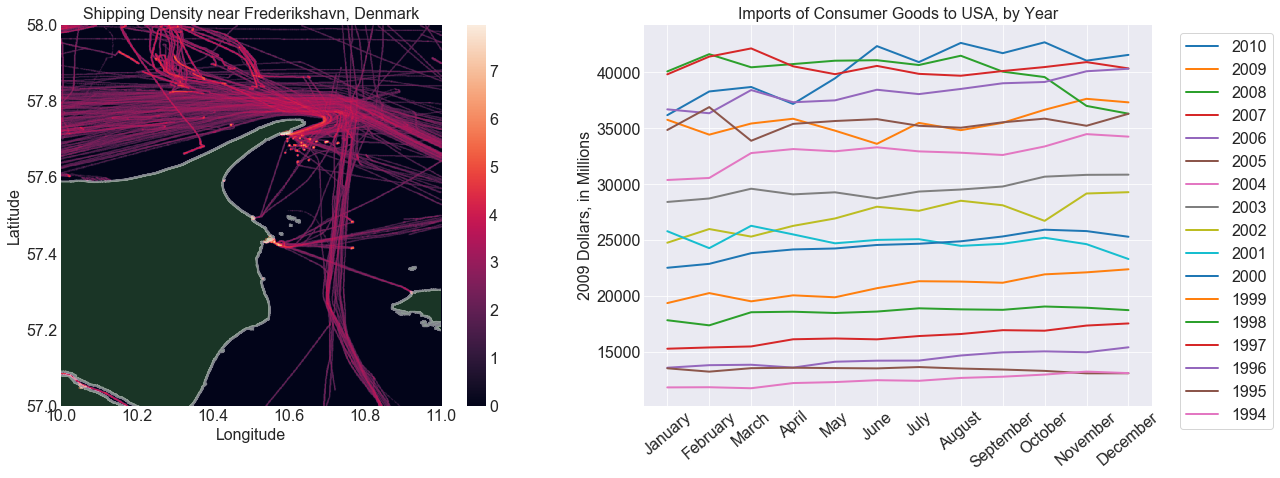

In [7]:
plt.figure(figsize=(20,7))
plot_density(values, plt.subplot(121))
plot_lines(line_data, plt.subplot(122))

The default plots already look pretty good, however, we can see a few different issues. In the case of the density plot, I had to plot the logarithm of that density in order to be able to see the full range of data. However, the colorbar in the legend also shows the logarithm of the density, which is not what we want. Furthermore, the vast majority of the plot ended up being roughly the same color.

In the case of the line plots, it's a bit hard to know which year is which, because different colors are reused. Furthermore, the color palette of the line plot is different from the color palette of the density plot which makes the plots look disconnected.

## Adjusting existing colormaps
### The Density Plot
Let's start with the density plot. The density of ocean traffic is represented in our data As a single value for each latitude/longitude coordinate. Converting that value to a color requires two steps: first, we use a normalizer to convert the density value to a number in the range 0 to 1. Next we use the color map to convert that normalized value to three numbers representing red green and blue (i.e., an RGB value).

Matplotlib has several classes for that. To normalize our density values, matplotlib provides both linear and nonlinear normalizers. For example, we can use the `Normalize` class to apply a linear scaling, or we can use classes like `PowerNorm` or `LogNorm` to use nonlinear scaling.
We will talk more about color maps in the next section, so, for now, we will use an existing color map that we retrieve using the function `get_cmap`.

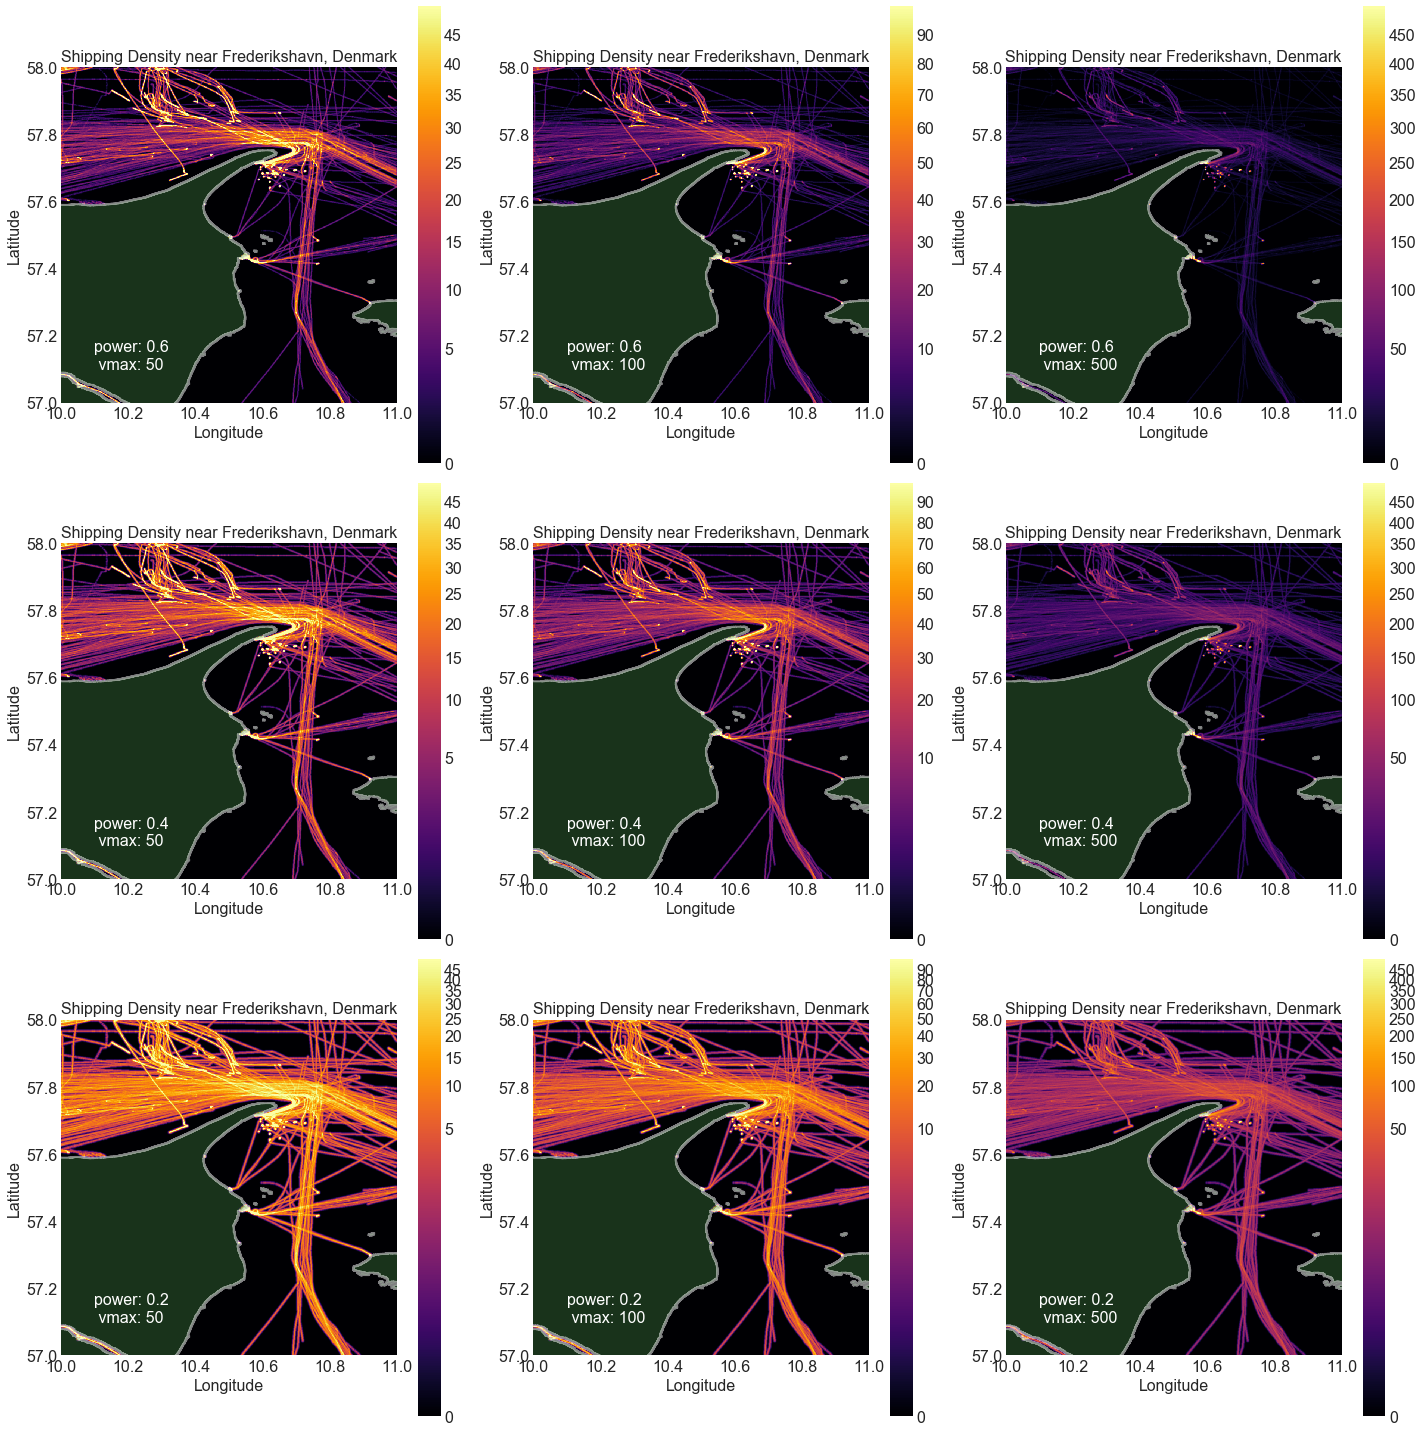

In [8]:
plt.figure(figsize=(20,20))

# load existing colormap, 'inferno' is also the defult in matplotlib
cmap = get_cmap('inferno')

# loop over different settings for PowerNorm for gridplit
for i, power in enumerate([.6, .4, .2]):
    for j, vmax in enumerate([50,100,500]):
        # create a PowerNorm instance
        norm = PowerNorm(power,vmin=0, vmax=vmax)

        plot_density(values, 
                     plt.subplot(3,3,(i*3+j)+1), 
                     cmap=cmap, norm=norm, 
                     annotation="power: {} \n vmax: {}".format(power, vmax))
plt.tight_layout()

### The Line Plot
Lets apply the same colormap to our lineplot. We'll use a linear normalization this time.

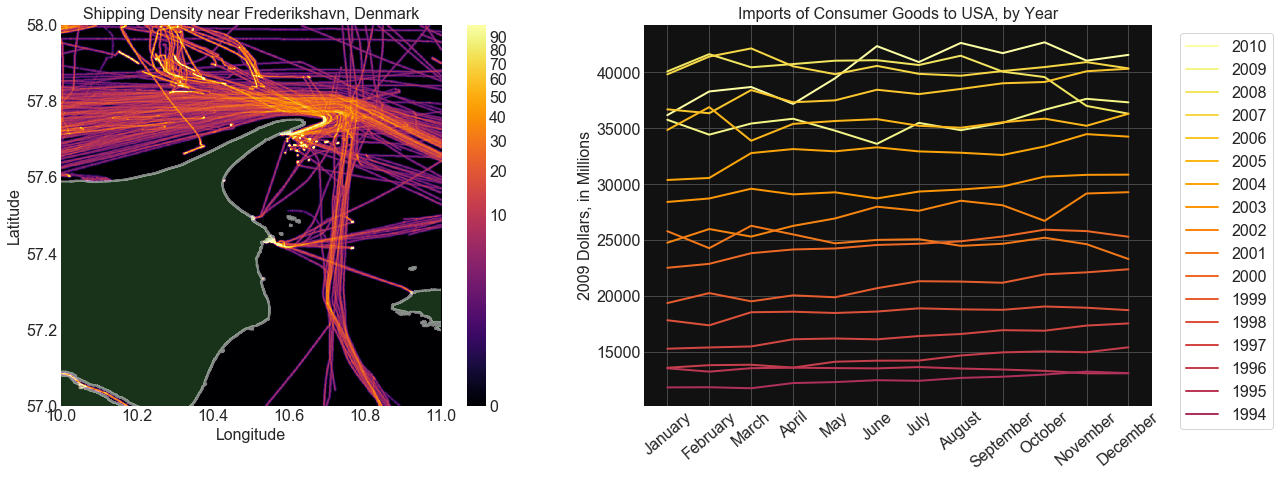

In [9]:
# define normalizers
line_norm = Normalize(1980, 2010)
density_norm = PowerNorm(0.3, vmin=0, vmax=100)

# make figure
plt.figure(figsize=(20,7))

plot_density(values, plt.subplot(121), cmap=cmap, norm=density_norm)
plot_lines(line_data, plt.subplot(122), cmap=cmap, norm=line_norm)

# set the background and grid colors
plt.gca().set_facecolor('#111111')
plt.grid(color='#555555')

Ok, that's a little better. At least the plots now look like they were both made by the same person. There is still a lot to quible about in these plots, but at least we now know how to control that.
Next, let's make our own colormap.

## Custom Color Palettes
There are many reasons to choose a color palette. Clarity is an important one, and a lot has be said about how to use color to make plots more readable. Matplotlib provides many predefined colormaps to help with this. Style is also important. Maybe you feel like 'inferno' does not quite send the right message for the data you are presenting or maybe you just want to conform to your company's in-house style. To do that, we need to define our own colormap.

As mentioned before, the color map is a class that converts a number range from 0 to 1 into an RGB triple. To build such class, matplotlib has a nice utility class called `LinearSegmentedColormap`. We can build such a class by only providing a list of colors; matplotlib then takes care of interpolating those colors to get a color for any value in [0, 1]. 

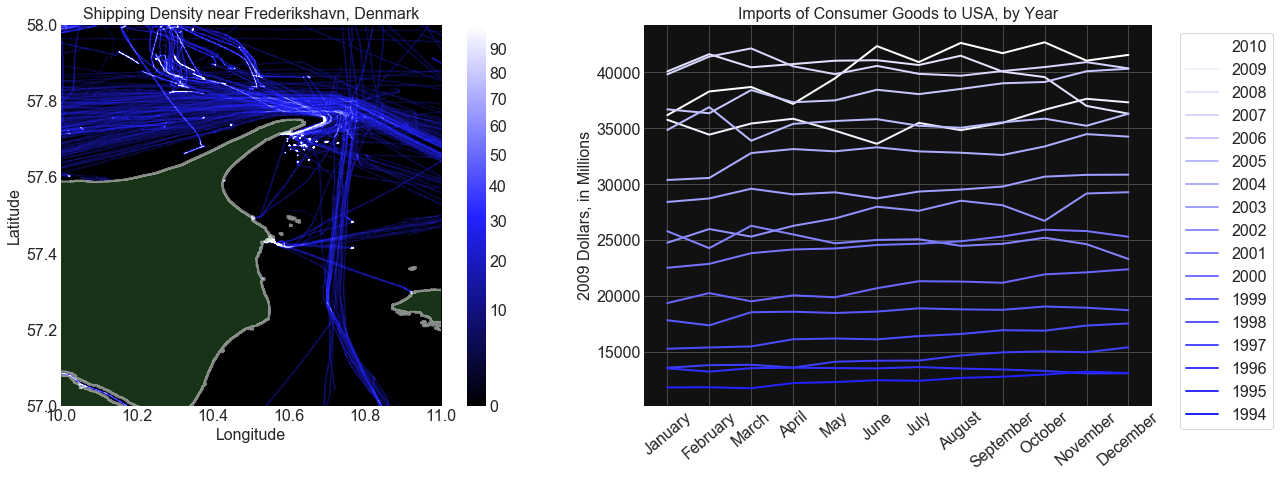

In [10]:
# make colormaps

# black -> blue -> white for the density plot
density_colors = ['#000000','#2222FF','#FFFFFF']
density_cmap = LinearSegmentedColormap.from_list('my_cmap', density_colors)
density_norm = PowerNorm(0.6, vmin=0, vmax=100)


# blue -> white for the line plot
line_colors = ['#2222FF','#FFFFFF']
line_cmap = LinearSegmentedColormap.from_list('my_cmap', line_colors)
line_norm = Normalize(vmin=1994,vmax=2010)


# make the plots
plt.figure(figsize=(20, 7))

plot_density(values, plt.subplot(121), cmap=density_cmap, norm=density_norm)
plot_lines(line_data, plt.subplot(122), cmap=line_cmap, norm=line_norm)

# set black background
plt.gca().set_facecolor('#111111')
plt.grid(color='#555555')

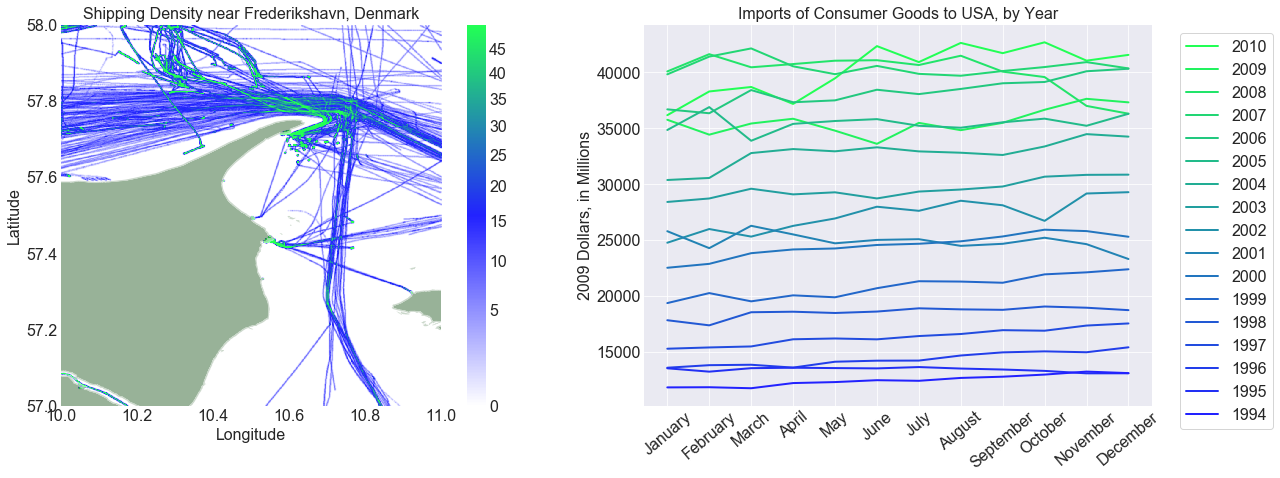

In [11]:
# or, of you prefer something that works on a white background:

# white -> blue -> green for the density plots
density_colors = ['#FFFFFF','#2222FF','#22FF55']
density_norm = PowerNorm(0.6, vmin=0, vmax=50)
density_cmap = LinearSegmentedColormap.from_list('my_cmap', density_colors)

# blue -> green for the line plots
line_colors = ['#2222FF','#22FF55']
line_norm = Normalize(vmin=1994,vmax=2010)
line_cmap = LinearSegmentedColormap.from_list('my_cmap', line_colors)

# make the plots
plt.figure(figsize=(20, 7))

plot_density(values, plt.subplot(121), cmap=density_cmap, norm=density_norm)
plot_lines(line_data, plt.subplot(122), cmap=line_cmap, norm=line_norm)


## Handy Resources
If you want to read more about colormaps, here are some additional resources:

- https://matplotlib.org/users/colormaps.html
- https://github.com/bokeh/colorcet
- http://www.kennethmoreland.com/color-advice/

and the docs for the classes that we used:
- https://matplotlib.org/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html#matplotlib.colors.LinearSegmentedColormap
- https://matplotlib.org/api/_as_gen/matplotlib.colors.Normalize.html#matplotlib.colors.Normalize
- https://matplotlib.org/api/_as_gen/matplotlib.colors.PowerNorm.html#matplotlib.colors.PowerNorm
- https://matplotlib.org/api/cm_api.html#matplotlib.cm.get_cmap

and the data sources:
- https://www.soefartsstyrelsen.dk/SikkerhedTilSoes/Sejladsinformation/AIS
- https://www.census.gov/foreign-trade/statistics/historical/index.html
- https://gadm.org/download_country_v3.html


In [12]:
# density_norm = PowerNorm(0.3, vmin=0, vmax=100)

# # make figure
# plt.figure(figsize=(50,50))

# plot_density(values, plt.subplot(111), cmap=cmap, norm=density_norm)